In [1]:
import numpy as np 
import cv2
import os
import shutil
import itertools
from sklearn.utils import shuffle
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
IMG_PATH = 'brain_tumor_dataset/'

# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
      IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
      for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
          img = IMG_PATH + CLASS + '/' + FILE_NAME
          if n < 5:
              shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
          elif n < 0.8*IMG_NUM:
              shutil.copy(img, 'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
          else:
              shutil.copy(img, 'VAL/'+ CLASS.upper() + '/' + FILE_NAME)

In [3]:
def load_data(dir_path, img_size = (100,100)):
    X = []
    y = []
    for yesorno in (sorted(os.listdir(dir_path))):
        for imgname in os.listdir(dir_path + yesorno):
            img = cv2.imread(dir_path + yesorno + '/' + imgname)
            X.append(img)
            if yesorno == 'NO':
              y.append(0)
            else:
              y.append(1)
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y



def plot_confusion_matrix(cm, classes,normalize = False,title = 'Confusion matrix',cmap = plt.cm.Blues):
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],horizontalalignment = "center",color = "white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [4]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val = load_data(VAL_DIR, IMG_SIZE)

193 images loaded from TRAIN/ directory.
10 images loaded from TEST/ directory.
50 images loaded from VAL/ directory.


C:\Users\admin\AppData\Local\Temp/ipykernel_9200/2678781355.py:12: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



In [5]:
def crop_imgs(set_name, add_pixels_value=0):
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations = 2)
        thresh = cv2.dilate(thresh, None, iterations = 2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

In [6]:
img = cv2.imread('brain_tumor_dataset/yes/Y108.jpg')
img = cv2.resize(img,dsize = IMG_SIZE,interpolation = cv2.INTER_CUBIC)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key = cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

In [7]:
X_train_crop = crop_imgs(set_name = X_train)
X_val_crop = crop_imgs(set_name = X_val)
X_test_crop = crop_imgs(set_name = X_test)

C:\Users\admin\AppData\Local\Temp/ipykernel_9200/1069890150.py:28: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



In [8]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [9]:
# saving new images to the folder
save_new_images(X_train_crop, y_train, folder_name = 'TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name = 'VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name = 'TEST_CROP/')

In [10]:
def preprocess_imgs(set_name, img_size):
    set_new = []
    for img in set_name:
        img = cv2.resize(img,dsize = img_size,interpolation = cv2.INTER_CUBIC)
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [11]:
X_train_prep = preprocess_imgs(set_name = X_train_crop, img_size = IMG_SIZE)
X_test_prep = preprocess_imgs(set_name = X_test_crop, img_size = IMG_SIZE)
X_val_prep = preprocess_imgs(set_name = X_val_crop, img_size = IMG_SIZE)


X_train_prep,y_train = shuffle(X_train_prep,y_train,random_state = 0)
X_test_prep,y_test = shuffle(X_test_prep,y_test,random_state = 0)
X_val_prep,y_val = shuffle(X_val_prep,y_val,random_state = 0)

In [12]:
# set the paramters we want to change randomly
demo_datagen = ImageDataGenerator(rotation_range = 15,width_shift_range = 0.05,height_shift_range = 0.05,
                                rescale = 1./255,shear_range = 0.05,brightness_range = [0.1, 1.5],horizontal_flip = True,
                                  vertical_flip = True)

In [13]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'

train_datagen = ImageDataGenerator(rotation_range = 15,width_shift_range = 0.1,height_shift_range = 0.1,
                                   shear_range = 0.1,brightness_range = [0.5, 1.5],horizontal_flip = True,
                                   vertical_flip = True,preprocessing_function = preprocess_input)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


train_generator = train_datagen.flow_from_directory(TRAIN_DIR,color_mode = 'rgb',target_size = IMG_SIZE,batch_size = 1,
                                                    class_mode = 'binary')


validation_generator = test_datagen.flow_from_directory(VAL_DIR,color_mode = 'rgb',target_size = IMG_SIZE,batch_size = 1,
                                                        class_mode = 'binary')

Found 287 images belonging to 2 classes.
Found 74 images belonging to 2 classes.


In [14]:
# load base model
vgg16_weight_path = 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = VGG16(weights=vgg16_weight_path,include_top=False, input_shape=IMG_SIZE + (3,))

In [15]:
model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.layers[0].trainable = False

model.compile(loss = 'binary_crossentropy',optimizer = RMSprop(lr = 1e-4),metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [19]:
EPOCHS = 30
es = EarlyStopping(monitor = 'val_accuracy', mode = 'max',patience = 6)

history = model.fit_generator(train_generator,steps_per_epoch = 193,epochs = EPOCHS,validation_data = validation_generator,
                              validation_steps = 50,callbacks = [es],)
model.save('braintumor.h5')

C:\Users\admin\AppData\Local\Temp/ipykernel_9200/3561665350.py:4: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/30
193/193 [==============================] - 59s 292ms/step - loss: 5.3134 - accuracy: 0.5233 - val_loss: 3.5968 - val_accuracy: 0.5200
Epoch 2/30
193/193 [==============================] - 57s 287ms/step - loss: 5.5814 - accuracy: 0.5751 - val_loss: 2.1191 - val_accuracy: 0.5600
Epoch 3/30
193/193 [==============================] - 57s 291ms/step - loss: 5.4710 - accuracy: 0.5337 - val_loss: 2.4204 - val_accuracy: 0.6000
Epoch 4/30
193/193 [==============================] - 58s 292ms/step - loss: 4.7606 - accuracy: 0.6218 - val_loss: 2.1790 - val_accuracy: 0.5400
Epoch 5/30
193/193 [==============================] - 58s 295ms/step - loss: 5.3680 - accuracy: 0.5855 - val_loss: 2.6966 - val_accuracy: 0.5400
Epoch 6/30
193/193 [==============================] - 58s 292ms/step - loss: 4.3186 - accuracy: 0.5699 - val_loss: 2.8367 - val_accuracy: 0.5200
Epoch 7/30
193/193 [==============================] - 58s 294ms/step - loss: 4.2175 - accuracy: 0.5907 - val_loss: 2.8457 - val_ac

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Brain is having the tumor


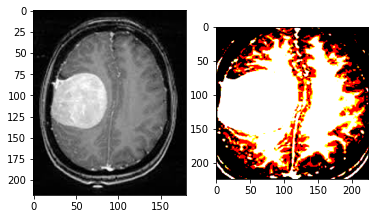

In [20]:
IMG_SIZE = (224,224)

# live test

model = load_model('braintumor.h5')
testimgpath = 'brain_tumor_dataset/yes/Y1.jpg'

def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-15 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(img,dsize=img_size,interpolation=cv2.INTER_CUBIC)
        set_new.append(preprocess_input(img))
    return np.array(set_new)



def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)


#read
plt.subplot(121)
test_img = cv2.imread(testimgpath)
plt.imshow(test_img)

#resize
# plt.subplot(132)
# test_img = cv2.resize(test_img,dsize=IMG_SIZE,interpolation=cv2.INTER_CUBIC)
# plt.imshow(test_img)

#crop and resize and preprocess for vgg
plt.subplot(122)
test_img = crop_imgs([test_img])
test_img = test_img.reshape(test_img.shape[1:])
test_img = preprocess_imgs([test_img],IMG_SIZE)
plt.imshow(test_img.reshape(test_img.shape[1:]))

#make prediction
pred = model.predict(test_img)
if pred<0.5:
  print('No Tumor')
else:
  print('Brain is having the tumor')